    # 04_support_vector_machines

    # 04_support_vector_machines
        ## 4-1 Setup
        ## 4-2 Linear SVM Classification
            ### 4-2-1 Large margin classification
            ### 4-2-2 Sensitivity to feature scales
            ### 4-2-3 Large margin *vs* margin violations
        ## 4-3 Non-linear classification
            ### 4-3-1 다항식 커널
            ### 4-3-2 유사도 특성 추가
            ### 4-3-3 가우시안 RBF 커널
            ### 4-3-4 계산 복잡도
        ## 4-4 SVM Regression
            ### 4-4-1 LinearSVR            
            ### 4-4-2 2차 다항 커널을 사용한 LinearSVR         
        ## 4-5 Exercise

## 4-1 Setup

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 4-2 Linear SVM Classification

### 4-2-1 Large margin classification

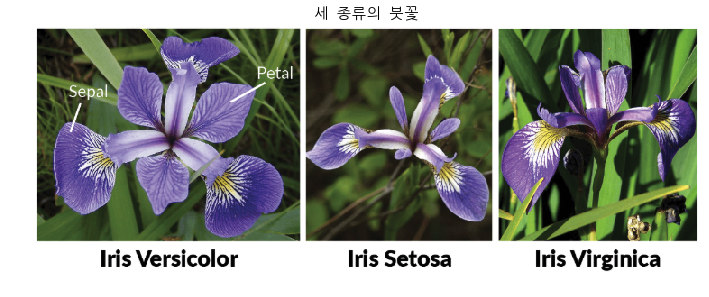

In [4]:
import matplotlib.image as mpimg

iris_img = mpimg.imread("./images/iris.png")
plt.figure(figsize=(12, 6))
plt.imshow(iris_img)
plt.axis("off")
plt.title("세 종류의 붓꽃")
plt.show()

In [5]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

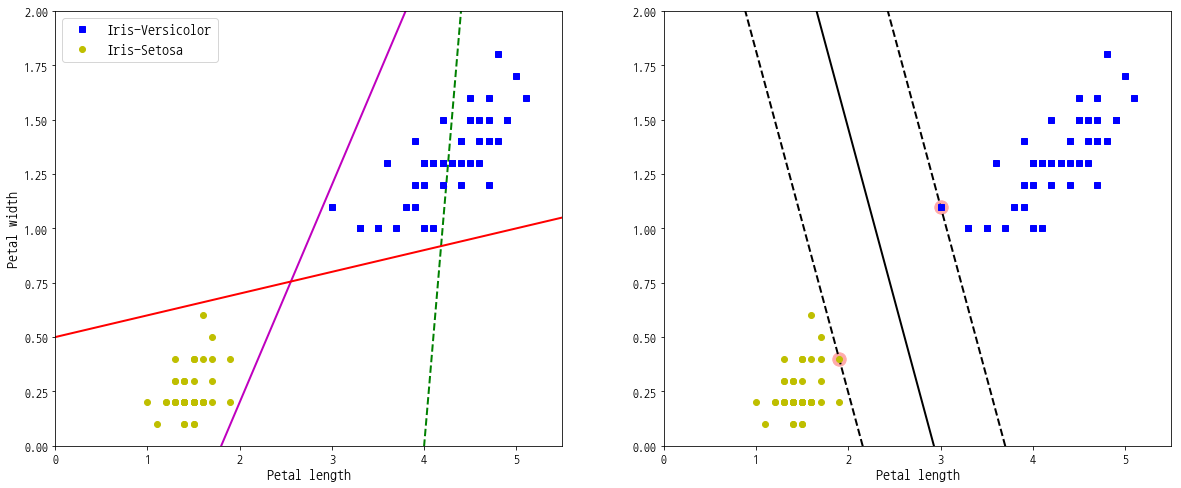

In [8]:
# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

* 왼쪽 그래프에 세 개(임의의 선)임 --> 클래스를 적절하게 분류하지 못하고 있음  
* 오른쪽에 보이는 결정 경계는 SVM모델로 만들어진 결정 경계이며 제일 가까훈 훈련 샘플로부터 가능한 멀리 있음  
    * SVM 분류기를 가장 폭이 넓은 범위를 찾는 것으로 그래서 Large Margin Classification이라 함  
    
---

* 이 범위 바깥쪽에 훈련 샘플을 더 추가해도 결정 경계에는 전혀 영향을 미치지가 않음  
* SVM은 이 폭에 위치한 샘플에 의해 전적으로 결정됨  
* 이런 sample을 support vector라고 함  

### 4-2-2 Sensitivity to feature scales

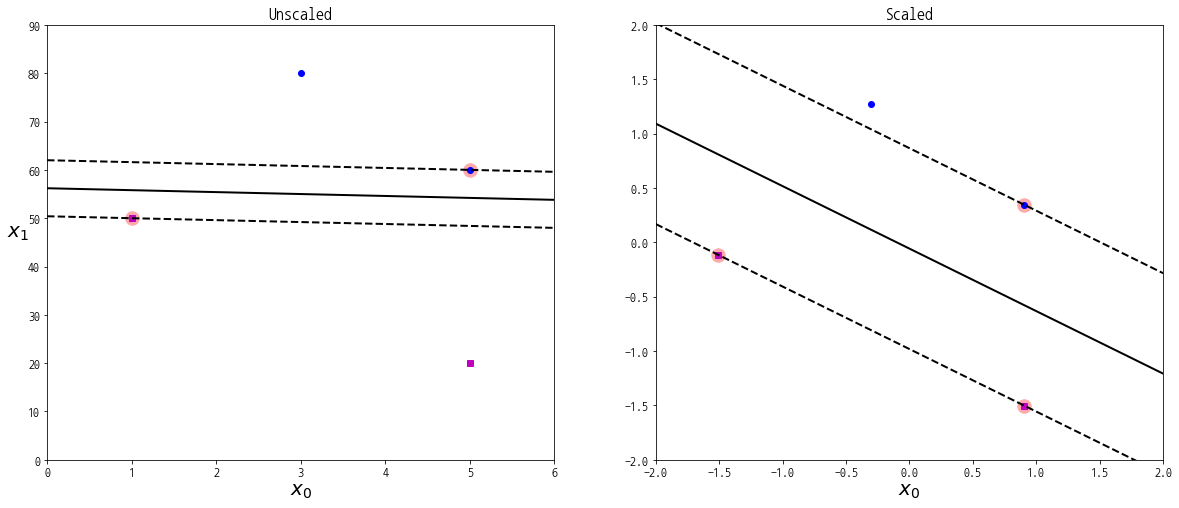

In [9]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$  ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

plt.show()

* SVM은 특성의 스케일에 민감함  
* 왼쪽 그래프에서 수직축의 스케일이 수평축의 스케일보다 훨씬 커서 가장 넓은 경계가 거의 수평에 가깝게 됨  
* 특성의 스케일을 조정하면 오른쪽 처럼 훨씬 좋아짐  

**Soft margin 분류**
* 모든 샘플이 결정경계 바깥쪽에 올바르게 분류되어 있다면 이를 hard margin classification이라 함  

---

** hard margin classification의 2가지 문제점**  
1. 데이터가 선형적으로 구분될 수 있어야함  
2. 이상치에 민감  

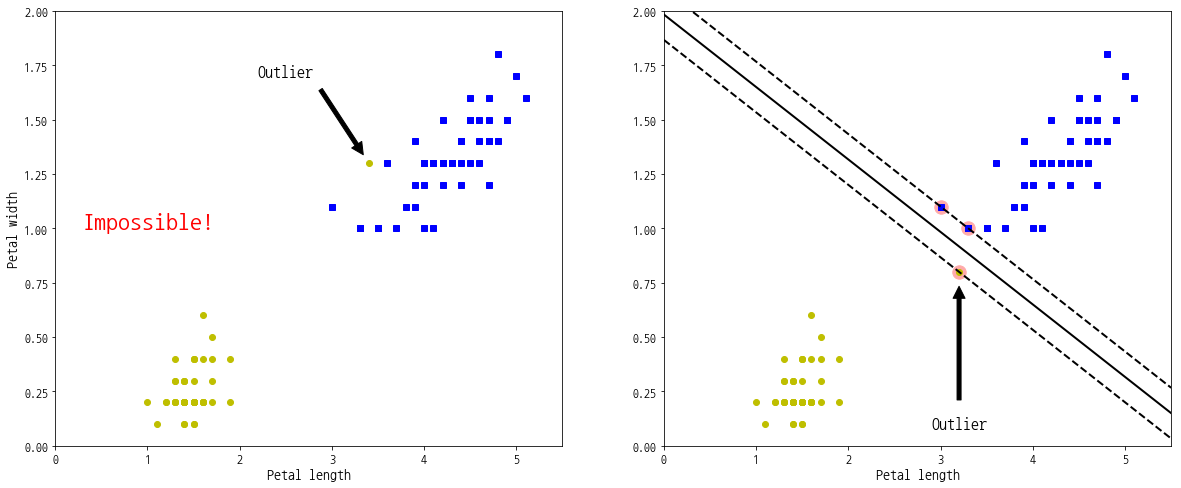

In [10]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.show()

* iris데이터셋에 이상치가 하나 있어서 hard margin을 찾을 수 없음.  
* 오른쪽 그래프의 결정 경계는 일반화가 잘 되지 않아서 폭을 가능한 한 넓게 유지하는 것과 마진 오류(margin violation)사이에 적절한 균형을 잡아야 함--> **soft margin classification**  

### 4-2-3 Large margin *vs* margin violations

* scikit-learn의 SVM모델에서는 C 하이퍼파라미터를 사용해 이 균형을 조절할 수 있음  
* C값을 줄이면 도로의 폭이 넓어지지만 마진 오류도 커짐  

In [12]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [13]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [14]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [15]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

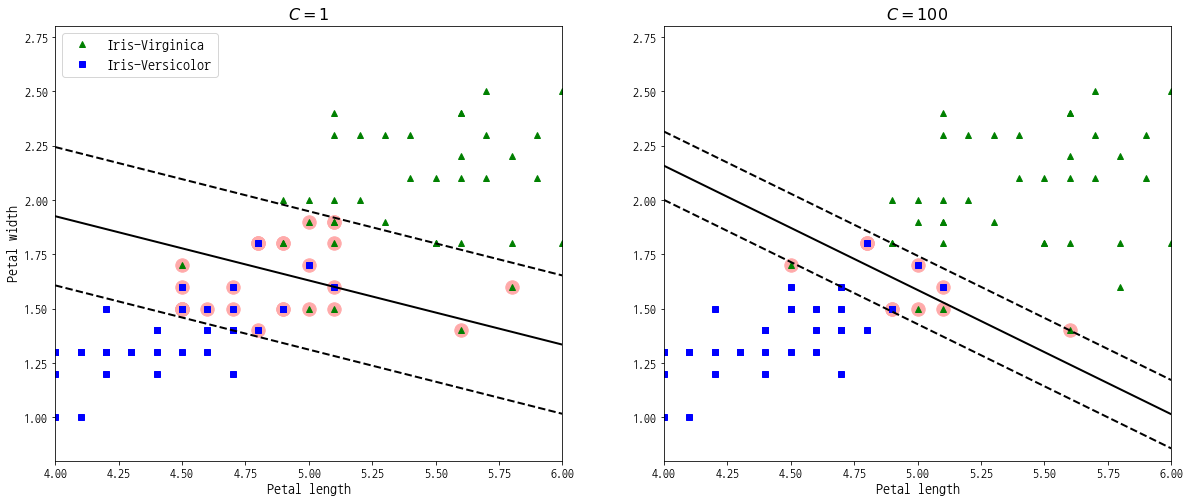

In [16]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.show()

* 위 그림은 선형적으로 구분되지 않는 데이터셋에 2개의 soft margin SVM 분류기로 만든 결정 경계와 마진을 보여줌  
* 왼쪽에서는 C 값을 사용해 분류기가 마진 오류를 적게 냈지만 마진이 좁아짐  

---

* 오른쪽에서는 작은 C값을 사용해 마진이 넓어졌지만 많은 샘플이 경계 안에 포함됨  
* 그러나 2번째 분류기가 더 잘 일반화될 것 같으며 모델링이 잘된 것 처럼 보임  
* 사실 대부분의 마진 오류는 결정 경계를 기준으로 올바른 클래스로 분류되기 때문에 이 훈련 세트에서 예측에러는 마진 오류보다 적음  

> SVM모델이 과대적합이라면 C를 감소시켜 모델을 규제할 수 있음  

## 4-3 Non-linear classification

* 선형 SVM 분류기가 효율적이고 많은 경우에 아주 잘 작동하지만, 선형적으로 분류할 수 없는 데이터셋이 많음  
* 비선형 데이터셋을 다루는 한가지 방법은 다항 특성과 같은 특성을 더 추가하는 것  
* 이렇게 하면 선형적으로 구분되는 데이터셋이 만들어질 수 있음  
* 왼쪽 그래프는 하나의 특성 $x_{1}$만을 가진 간단한 데이터셋을 나타냄  

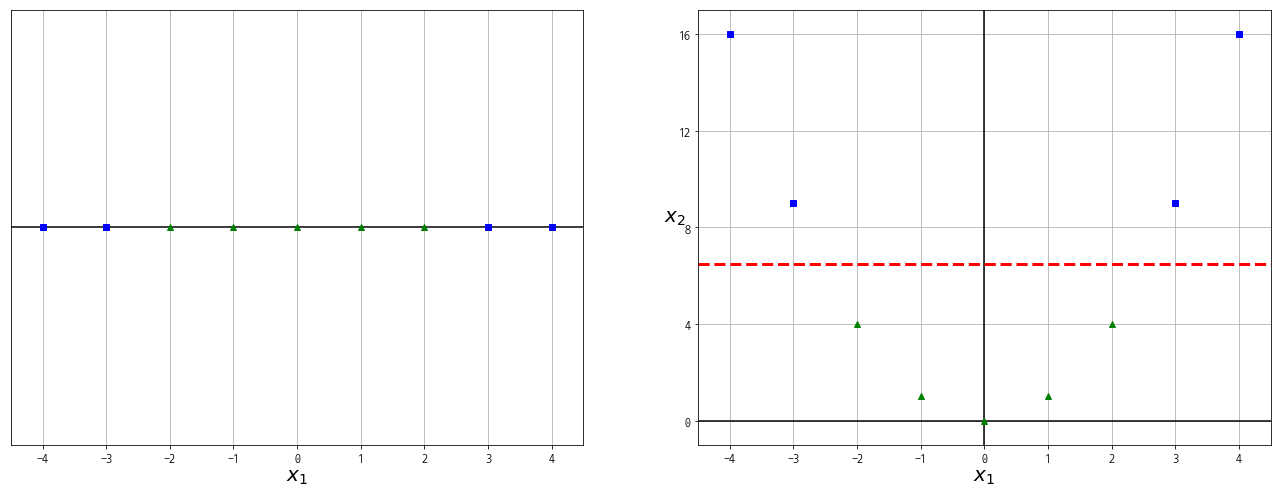

In [18]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

plt.show()

* 이 데이터셋은 선형적으로 구분이 안됨  
* 하지만 두번째 특성 $x_{2}=\left(x_{1} \right)^{2}$을 추가하여 만들어진 데이터는 2차원 데이터셋은 구분이 가능함  

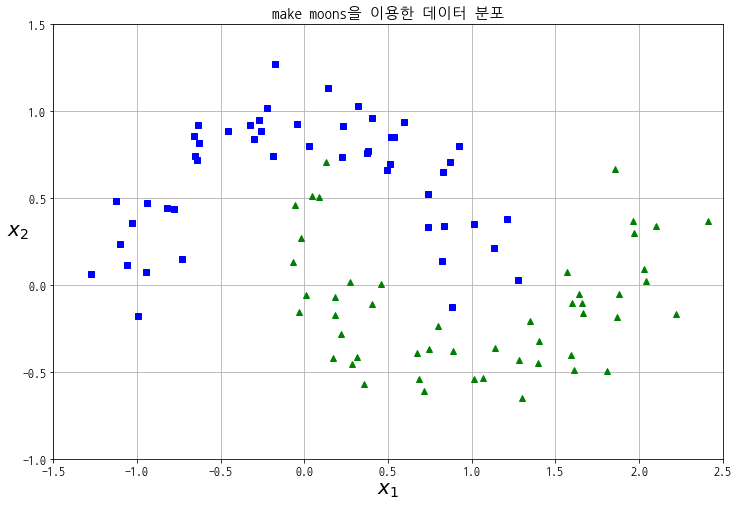

In [50]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plt.figure(figsize=(12, 8))
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title("make moons을 이용한 데이터 분포")
plt.show()

In [28]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

/home/ururu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

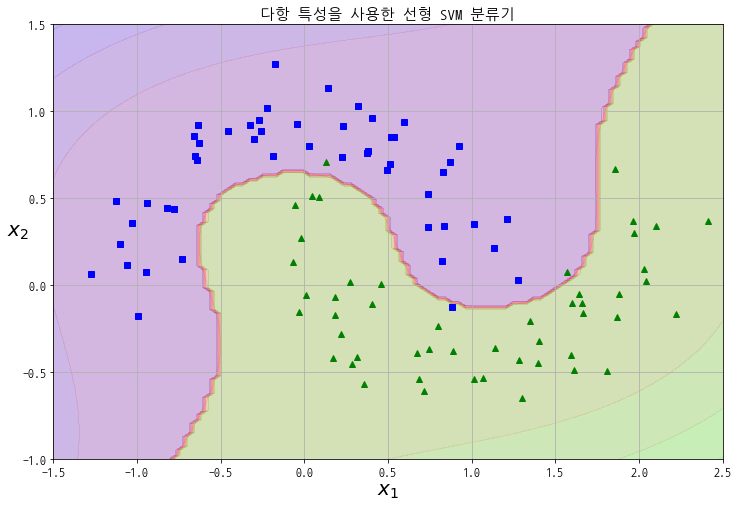

In [49]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plt.figure(figsize=(12, 8))    
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title("다항 특성을 사용한 선형 SVM 분류기")

plt.show()

### 4-3-1 다항식 커널           
            
* 다항식 특성은 추가하는 것은 간단하고 모든 머신러닝 알고리즘에서 잘 작동함  
* 그러나 낮은 차수의 다항식은 복잡한 데이터셋을 잘 표현하지 못하고  
높은 차수의 다항식은 굉장히 많은 특성을 추가하므로 모델을 느리게 함  

---

* SVM을 사용할 땐 **kernel trick**이라는 거의 기적에 가까운 수학적 기교를 적용할 수 있음  
* 실제로는 특성을 추가하지 않으면서 다항식 특성을 많이 추가한 것과 같은 결과를 얻을 수 있음  
* 어떤 특성도 추가하지 않기 때문에 엄청난 수의 특성 조합이 생기지 않음  

In [32]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [33]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=100,
  decision_function_shape='ovr', degree=10, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

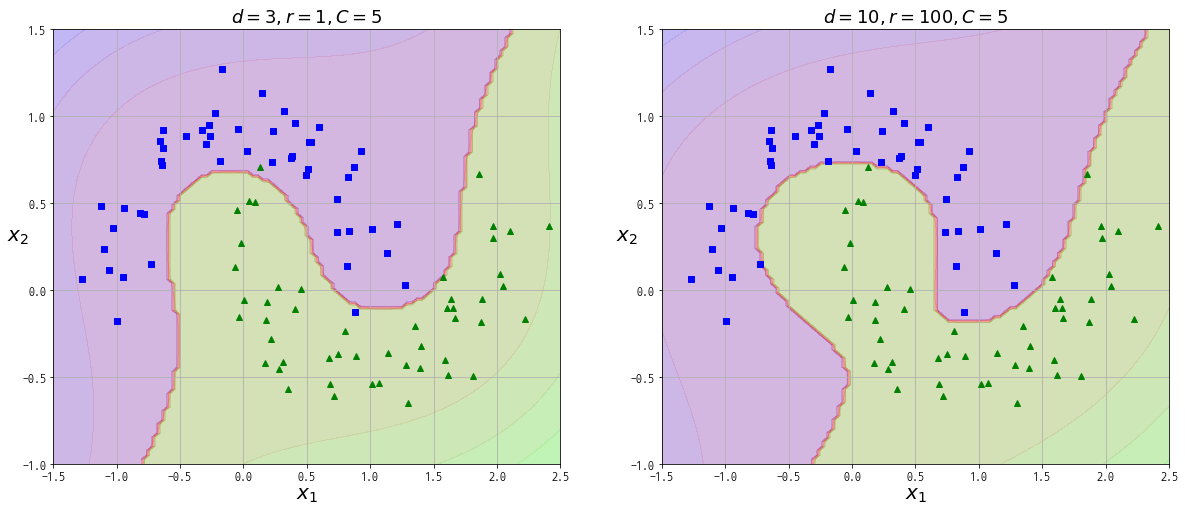

In [34]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

plt.show()

* 왼쪽은 3차 다항식 커널을 사용해 SVM분류기를 훈련시킴  
* 오른쪽은 10차 다항식 커널을 사용해 SVM분류기를 훈련시킴 --> 모델이 과대적합이라면 다항식의 차수를 줄이고 과소적합이라면 다항식의 차수를 늘려야함  
* 매개변수 `coef0`는 모델이 높은 차수와 낮은 차수에 얼마나 영향을 받을지 조절

 ### 4-3-2 유사도 특성 추가            
            
* 비선형 특성을 다루는 또 다른 기법은 각 sample이 특정 **landmark**와 얼마나 닮았는지 측정하는 **similarity function**로 계산한 특성을 추가함  

---

**Gauss Radial Basis Function**  
$\phi _{ \gamma  }(x,\ell )=e^{(-\gamma\left\| x-\ell\right\|^{2})}$  
* $\gamma$는 0보다 커야 하며 값이 작을수록 폭이 넓은 종모양이 됨  
* 이 함수의 값은 0(landmark에서 아주 멀리 떨어진 경우) ~ 1(landmark와 같은 위치일 경우)까지 변화하며 종 모양으로 나타남  

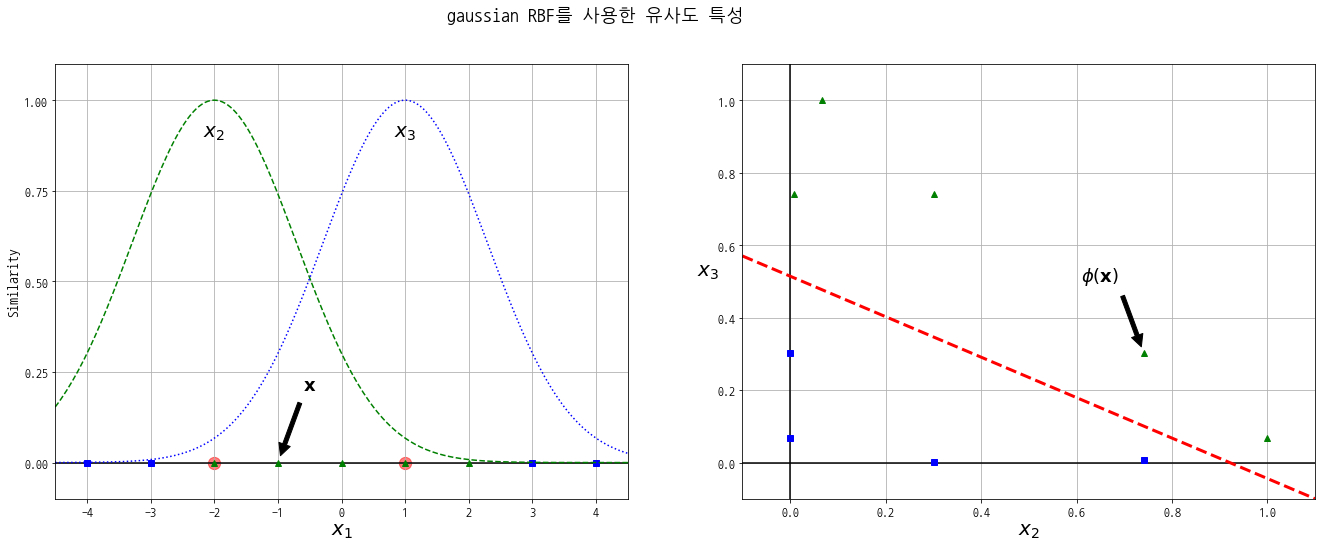

In [43]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(20, 8)).suptitle("gaussian RBF를 사용한 유사도 특성", fontsize=18)

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])

plt.subplots_adjust(right=1)

plt.show()

* $x_{1}=-1$의 경우 이 sample은 첫 번째 landmark에서 1만큼 떨어져 있고 두 번째 landmark에서 2만큼 떨어져있음  
* 따라서 새로 만든 특성은 $x_{2}=e^{-0.3 \cdot 1^{2}} \approx 0.74$와 $x_{3}=e^{-0.3 \cdot 2^{2}} \approx 0.30$   
* 오른쪽 그래프는 원본 특성은 빠진 변환된 데이터셋이며 선형적으로 구분이 가능함

### 4-3-3 가우시안 RBF 커널

* 유사도 특성을 많이 추가하는 것과 같은 비슷한 결과를 실제로 특성을 추가하지 않고 얻을 수 있음  

In [44]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


In [45]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

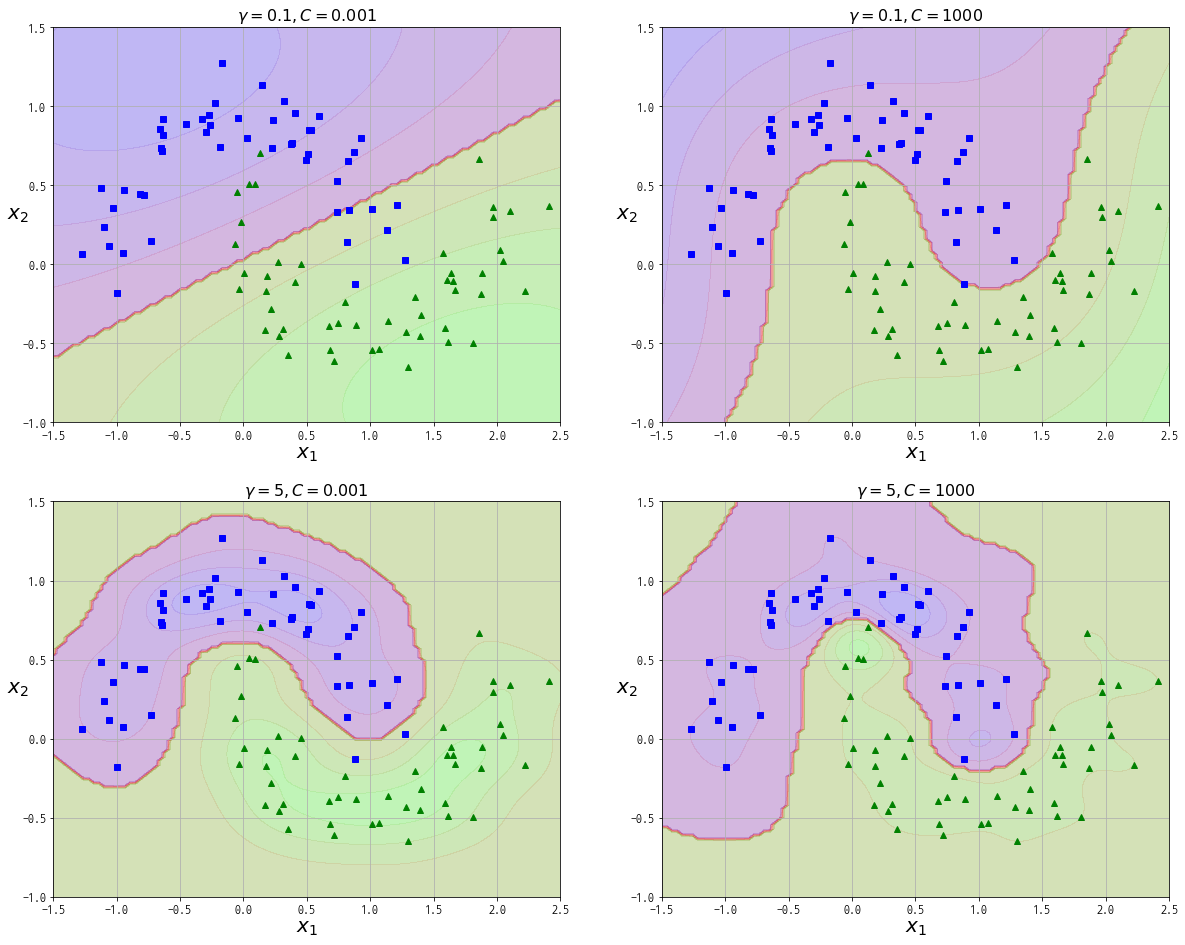

In [48]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(20, 16))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

plt.show()

* gamma를 증가시키면 종 모양 그래프가 좁아져서 각 샘플의 영향 범위가 작아짐  
* 결정 경계가 조금 더 불규칙해지고 각 샘플을 따라 구불구불하게 휘어짐  
* 반대로 작은 gamma값은 넓은 종 모양 그래프를 만들며 샘플이 넓은 범위에 걸쳐 영향을 주므로 결정 경계가 더 부드러워짐  
* 하이퍼파라미터가 $\gamma$가 규제의 역할을 담당하게 되며 모델이 과대적합일 경우엔 감소시켜야 하고 과소적합일 경우에 증가시켜야함(하이퍼파라미터 C와 비슷)  

---

* LinearSVC가 SVC(kernel="linear")보다 훨씬 빠름  
* 대부분의 경우 gaussian RBF커널이 잘 들어 맞음

### 4-3-4 계산 복잡도

* `LinearSVC` 파이썬 클래스는 선형 SVM을 위한 최적화된 알고리즘을 구현한 liblinear 라이브러리를 기반으로 함  
* 이 라이브러리는 커널 트릭을 지원하지 않지만 훈련 샘플과 특성수에 거의 선형적으로 늘어남  
* 이 알고리즘의 훈련 시간 복잡도는 대략 O(m x n)정도  

---

* 정밀도를 높이면 알고리즘의 수행 시간이 길어짐  
* 이는 허용오차 하이퍼파라미터 $\varepsilon $으로 조절함(scikit-learn에서 매개변수는 tol)  
* 대부분의 분류 문제는 허용오차를 기본값으로 두변 잘 작동함(SVC의 tol=0.001, LinearSVC의 tol=0.0001)임  

---

* SVC는 커널 트릭 알고리즘을 구현한 libsvm 라이브러리를 기반으로 함  
* 훈련의 시간 복잡도는 보통 $O(m^{2}\times n)$ ~ $O(m^{3}\times n)$--> 이는 훈련 샘플 수가 커지면 엄청나게 느려짐  
* 그러나 sparse features(샘플에 0이 아닌 특성이 몇 개 없는 경우)에는 확장이 잘됨  

**SVM 분류를 위한 Scikit-learn python class 비교**  

| Python Class  | time complexity                         | support external memory | need to adjust-scale | kernel trick |
|---------------|-----------------------------------------|-------------------------|----------------------|--------------|
| LinearSVC     | $O(m \times n)$                         | No                      | Yes                  | No           |
| SGDClassifier | $O(m \times n)$                         | Yes                     | Yes                  | No           |
| SVC           | $O(m^{2} \times n)$~$O(m^{3} \times n)$ | No                      | Yes                  | Yes          |

## 4-4 SVM Regression
### 4-4-1 LinearSVR

> SVM 알고리즘은 다목적으로 사용할 수 있음  
선형, 비선형 분류뿐만 아니라 선형, 비선형 회귀에도 사용할 수 있음  
**회귀에 적용하는 방법은 목표를 반대로 설정**  
일정한 마진 오류 안에서 두 클래스간의 범위가 가능한 한 최대가 되도록 하는 대신, SVM회귀는 제한된 마진 오류(범위 밖의 샘플) 안에서 도로 안에 가능한 한 많은 샘플이 들어가도록 학습  
도로의 폭은 하이퍼파라미터 $\varepsilon$으로 조절  

In [51]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [52]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)

In [53]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

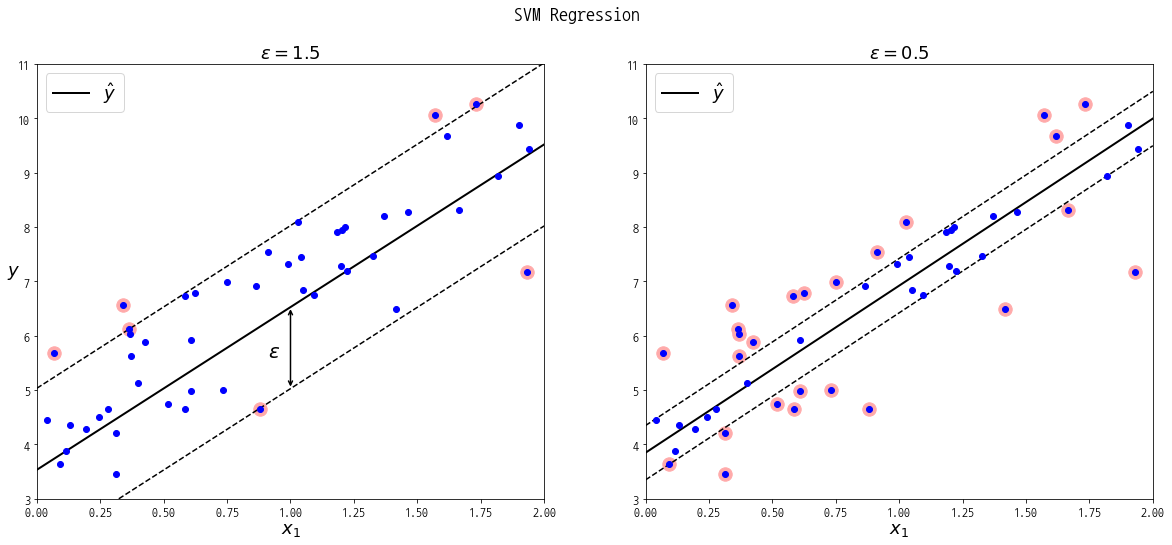

In [56]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

plt.figure(figsize=(20, 8)).suptitle("SVM Regression", fontsize=18)
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)

plt.show()

* 무작위로 생성한 선형 데이터셋에 훈련시킨 두 개의 선형 SVM 회귀 모델을 보여줌  
* 하나는 마진을 크게 ($\varepsilon=1.5$)하고 다른 하나는 마진을 작게($\varepsilon=0.5$)하여 구성  
* margin 안에서는 훈련 샘플이 추가되어도 모델의 예측에는 영향이 없음 -> **$\varepsilon$-insensitive**

### 4-4-2 2차 다항 커널을 사용한 LinearSVR

* 훈련 데이터의 스케일을 맞추고 평균을 0으로 맞춰야 함  
* 비선형 회귀 작업을 처리하려면 커널 SVM 모델을 사용

In [57]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

* SVR은 SVC의 회귀 버전이고  
* LinearSVR은 LinearSVC의 회귀 버전임  

---

* LinearSVR은(LinearSVC처럼) 필요한 시간이 훈련 세트의 크기에 비례해서 선형적으로 늘어남  
* SVR은 SVC처럼 훈련 세트가 커지면 훨씬 느려짐  

In [58]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="auto")
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [59]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="auto")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="auto")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

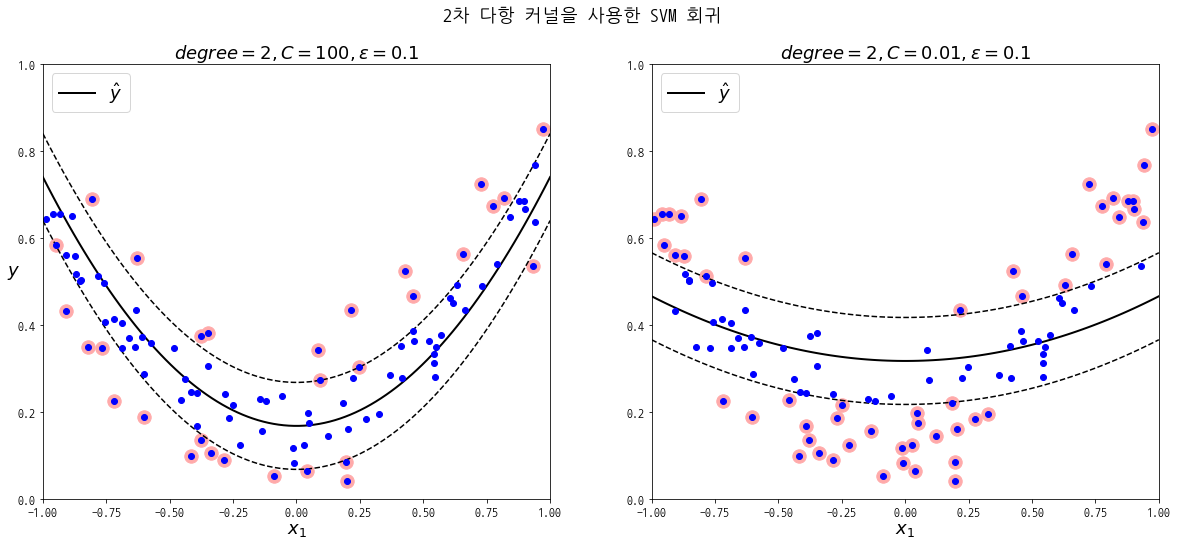

In [61]:
plt.figure(figsize=(20, 8)).suptitle("2차 다항 커널을 사용한 SVM 회귀", fontsize=18)
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)

plt.show()

* 비선형 회귀 작업을 처리하려면 커널 SVM 모델을 사용함  
* 왼쪽 그래프는 규제가 거의 없고(큰 C값), 오른쪽 그래프는 규제가 훨씬 많음(작은 C값)

## 4-5 Exercise

1. 서포트 벡터 머신의 근본 아이디어는 무엇인가?
2. 서포트 벡터가 무엇인가?
3. SVM을 사용할 때 입력값의 스케일이 왜 중요한가?
4. SVM 분류기가 샘플을 분류할 때 신뢰도 점수와 확률을 출력할 수 있는가?  
5. 수백만 개의 샘플과 수백 개의 특성을 가진 훈련 세트에 SVM 모델을 훈련시키려면 원 문제와 쌍대 문제 중 어떤 것을 사용해야하는 가?  
6. RBF 커널을 사용해 SVM 분류기를 훈련시켰더니 훈련 세트에 과소적합된 것 같음 $\gamma(gamma)$를 증가시켜야 하는가? 감소시켜야 하는가? C의 경우는 어떤가?  
7. 이미 만들어진 QP 알고리즘 라이브러리를 사용해 소프트 마진 선형 SVM 분류기를 학습시키려면 QP 매개변수(H, f, A, b)를 어떻게 지정해야 하는가?  
8. 선형적으로 분리되는 데이터셋에 LinearSVC를 훈련시켜보라. 그 다음 같은 데이터셋에 SVC와 SGDClassifier를 적용  
9. MNIST 데이터셋에 SVM 분류기를 훈련시켜보라. SVM 분류기는 이진 분류기라서 OvA 전략을 사용해 10개의 숫자를 분류해야 함. 처리 속도를 높이기 위해 작은 검증 세트로 하이퍼파라미터를 조정하는 것이 좋음
10. 캘리포니아 주택 가격 데이터셋에 SVM 회귀를 훈련시켜보라

# Small weight vector results in a large margin

In [ ]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

plt.figure(figsize=(12, 3.2))
plt.subplot(121)
plot_2D_decision_function(1, 0)
plt.subplot(122)
plot_2D_decision_function(0.5, 0, ylabel=False)

plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris-Virginica

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)
svm_clf.predict([[5.3, 1.3]])

# Extra material

## 4-5 SVM Theory

In [64]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

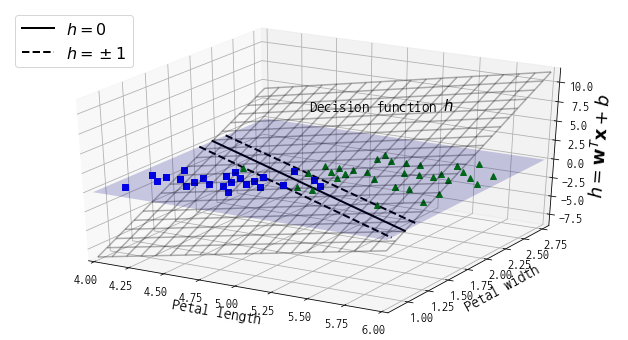

In [65]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=15)
    ax.set_xlabel(r"Petal length", fontsize=15)
    ax.set_ylabel(r"Petal width", fontsize=15)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

plt.show()

## Training time

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

In [ ]:
import time

tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10
plt.semilogx(tols, times)

## Linear SVM classifier implementation using Batch Gradient Descent

In [ ]:
# Training set
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris-Virginica

In [ ]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if t==0, +1 if t==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

In [ ]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [ ]:
print(svm_clf.intercept_, svm_clf.coef_)

In [ ]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

In [ ]:
yr = y.ravel()
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris-Virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha = 0.017, max_iter = 50, tol=-np.infty, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # -1 if t==0, +1 if t==1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


# Exercise solutions

## 1. to 7.

See appendix A.

# 8.

_Exercise: train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce roughly the same model._

Let's use the Iris dataset: the Iris Setosa and Iris Versicolor classes are linearly separable.

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=100000, tol=-np.infty, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

Let's plot the decision boundaries of these three models:

In [ ]:
# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris-Versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris-Setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

Close enough!

# 9.

_Exercise: train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?_

First, let's load the dataset and split it into a training set and a test set. We could use `train_test_split()` but people usually just take the first 60,000 instances for the training set, and the last 10,000 instances for the test set (this makes it possible to compare your model's performance with others): 

In [ ]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

X = mnist["data"]
y = mnist["target"]

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

Many training algorithms are sensitive to the order of the training instances, so it's generally good practice to shuffle them first:

In [ ]:
np.random.seed(42)
rnd_idx = np.random.permutation(60000)
X_train = X_train[rnd_idx]
y_train = y_train[rnd_idx]

Let's start simple, with a linear SVM classifier. It will automatically use the One-vs-All (also called One-vs-the-Rest, OvR) strategy, so there's nothing special we need to do. Easy!

In [ ]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

Let's make predictions on the training set and measure the accuracy (we don't want to measure it on the test set yet, since we have not selected and trained the final model yet):

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

Wow, 86% accuracy on MNIST is a really bad performance. This linear model is certainly too simple for MNIST, but perhaps we just needed to scale the data first:

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [ ]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

In [ ]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

That's much better (we cut the error rate in two), but still not great at all for MNIST. If we want to use an SVM, we will have to use a kernel. Let's try an `SVC` with an RBF kernel (the default).

**Warning**: if you are using Scikit-Learn ≤ 0.19, the `SVC` class will use the One-vs-One (OvO) strategy by default, so you must explicitly set `decision_function_shape="ovr"` if you want to use the OvR strategy instead (OvR is the default since 0.19).

In [ ]:
svm_clf = SVC(decision_function_shape="ovr", gamma="auto")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

In [ ]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

That's promising, we get better performance even though we trained the model on 6 times less data. Let's tune the hyperparameters by doing a randomized search with cross validation. We will do this on a small dataset just to speed up the process:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

In [ ]:
rnd_search_cv.best_estimator_

In [ ]:
rnd_search_cv.best_score_

This looks pretty low but remember we only trained the model on 1,000 instances. Let's retrain the best estimator on the whole training set (run this at night, it will take hours):

In [ ]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

Ah, this looks good! Let's select this model. Now we can test it on the test set:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

Not too bad, but apparently the model is overfitting slightly. It's tempting to tweak the hyperparameters a bit more (e.g. decreasing `C` and/or `gamma`), but we would run the risk of overfitting the test set. Other people have found that the hyperparameters `C=5` and `gamma=0.005` yield even better performance (over 98% accuracy). By running the randomized search for longer and on a larger part of the training set, you may be able to find this as well.

## 10.

_Exercise: train an SVM regressor on the California housing dataset._

Let's load the dataset using Scikit-Learn's `fetch_california_housing()` function:

In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

Split it into a training set and a test set:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Don't forget to scale the data:

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Let's train a simple `LinearSVR` first:

In [ ]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

Let's see how it performs on the training set:

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

Let's look at the RMSE:

In [ ]:
np.sqrt(mse)

In this training set, the targets are tens of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors somewhere around $10,000. Not great. Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for `C` and `gamma`:

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

In [ ]:
rnd_search_cv.best_estimator_

Now let's measure the RMSE on the training set:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)